# Implementation of Blood Detection through CNN

### Importing Libraries

In [3]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

In [1]:
ls

blood_noblood_detection_cnn.ipynb  dataset/


### Setting Image width and Height

In [2]:
fast_run = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

### Checking training images and eliminating damaged images

In [5]:
for filename in os.listdir('dataset/train_set/'):
    if filename.endswith('.jpg'):
        try:
            img = Image.open('dataset/train_set/'+filename)  
            img.verify()  
        except (IOError, SyntaxError) as e:
            print(filename)
            os.remove('dataset/train_set/'+filename)

### Checking training images and eliminating damaged images

In [6]:
for filename in os.listdir('dataset/test_set/'):
    if filename.endswith('.jpg'):
        try:
            img = Image.open('dataset/test_set/'+filename)  
            img.verify() 
        except (IOError, SyntaxError) as e:
            print(filename)
            os.remove('dataset/test_set/'+filename)

### Labelling the images

In [7]:
filenames = os.listdir("dataset/train_set/")
categories = []
for filename in filenames:
    category = filename.split('_')[0]
    if category == 'blood':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [8]:
df

,filename,category
0,blood_19.jpg,1
1,noblood_259.jpg,0
2,blood_25.jpg,1
3,noblood_271.jpg,0
4,noblood_265.jpg,0
...,...,...
584,noblood_297.jpg,0
585,blood_28.jpg,1
586,noblood_268.jpg,0
587,blood_14.jpg,1


# Convolution Neural Network

### Building the model

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

### Prepare data
Because we will use image genaretor with class_mode="categorical". We need to convert column category into string. 

In [14]:
df["category"] = df["category"].replace({0: 'noblood', 1: 'blood'}) 


### Splitting data into train and test and resetting indices.

In [157]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [156]:
train_df

,filename,category
0,blood_35.jpg,blood
1,blood_137.jpg,blood
2,noblood_101.jpg,noblood
3,noblood_197.jpg,noblood
4,blood_41.jpg,blood
...,...,...
466,noblood_277.jpg,noblood
467,noblood_29.jpg,noblood
468,blood_244.jpg,blood
469,noblood_154.jpg,noblood


In [17]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

### Training Generator

In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "dataset/train_set/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 471 validated image filenames belonging to 2 classes.


### Validation Generator

In [19]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "dataset/train_set/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 117 validated image filenames belonging to 2 classes.


/opt/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


### Model Fitting is done.

In [20]:
epochs=3 if fast_run else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
31/31 [==============================] - 29s 926ms/step - loss: 1.0883 - accuracy: 0.7171 - val_loss: 3.3725 - val_accuracy: 0.4381
Epoch 2/50
31/31 [==============================] - 30s 976ms/step - loss: 0.7862 - accuracy: 0.7522 - val_loss: 2.4697 - val_accuracy: 0.4476
Epoch 3/50
31/31 [==============================] - 27s 878ms/step - loss: 0.5938 - accuracy: 0.8136 - val_loss: 3.2540 - val_accuracy: 0.4286
Epoch 4/50
31/31 [==============================] - 27s 871ms/step - loss: 0.6324 - accuracy: 0.7741 - val_loss: 6.2747 - val_accuracy: 0.4667
Epoch 5/50
31/31 [==============================] - 27s 872ms/step - loss: 0.5572 - accuracy: 0.8114 - val_loss: 5.6934 - val_accuracy: 0.4667
Epoch 6/50
31/31 [==============================] - 29s 920ms/step - loss: 0.5612 - accuracy: 0.8180 - val_loss: 2.6370 - val_accuracy: 0.4286
Epoch 7/50
31/31 [==============================] - 27s 856ms/step

Epoch 22/50
31/31 [==============================] - 28s 888ms/step - loss: 0.2424 - accuracy: 0.8969 - val_loss: 0.7394 - val_accuracy: 0.7619
Epoch 23/50
31/31 [==============================] - 28s 893ms/step - loss: 0.2810 - accuracy: 0.8882 - val_loss: 0.5697 - val_accuracy: 0.7714
Epoch 24/50
31/31 [==============================] - 28s 904ms/step - loss: 0.2502 - accuracy: 0.8947 - val_loss: 0.4930 - val_accuracy: 0.8857
Epoch 25/50
31/31 [==============================] - 28s 916ms/step - loss: 0.2862 - accuracy: 0.8991 - val_loss: 1.2013 - val_accuracy: 0.7524
Epoch 26/50
31/31 [==============================] - 28s 904ms/step - loss: 0.2337 - accuracy: 0.9079 - val_loss: 0.5407 - val_accuracy: 0.8381
Epoch 27/50
31/31 [==============================] - 28s 904ms/step - loss: 0.2675 - accuracy: 0.8882 - val_loss: 0.8770 - val_accuracy: 0.8190
Epoch 28/50
31/31 [==============================] - 28s 903ms/step - loss: 0.2377 - accuracy: 0.9032 - val_loss: 0.4058 - val_accuracy:

### Saving Weights

In [21]:
model.save_weights("model_final.h5")


# Testing the trained model.

In [147]:
test_filenames = os.listdir("dataset/test_set/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [148]:
nb_samples

233

### Testing data generation

In [149]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "dataset/test_set/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 233 validated image filenames.


### Predicting Model

In [150]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

### Returns the indices of the maximum values along an axis.

In [151]:
x = np.argmax(predict, axis=-1)


### Adding a column in a dataframe

In [152]:
test_df['category'] = x

### Converting the predicted output as a label

In [154]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

### Results

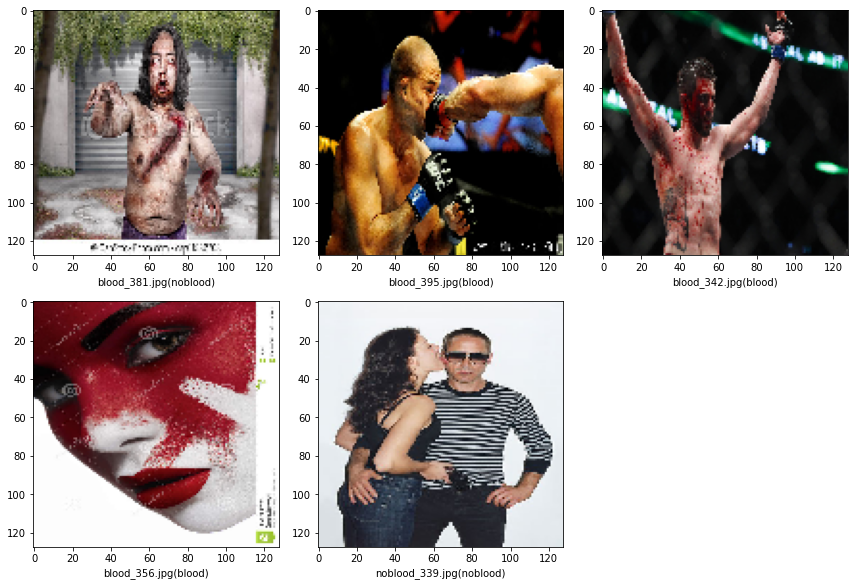

In [159]:
sample_test = test_df.head(5)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("dataset/test_set/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()